In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np

from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import darkmode; darkmode.run(100)
import matplotlib.pyplot as plt
import json

category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal',
                  'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
colormap = np.array([[  0,   0,   0],
                     [192,   0, 128],
                     [  0, 128, 192],
                     [  0, 128,  64],
                     [128,   0,   0],
                     [ 64,   0, 128],
                     [ 64,   0, 192],
                     [192, 128,  64],
                     [192, 192, 128],
                     [ 64,  64, 128],
                     [128,   0, 192]]
                    )

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.dataset_path = "/opt/ml/segmentation/input/data/"
        
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(self.dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Clothing = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
            # return images , masks
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
    
    def get_masked_img(self,image_id) :
        
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(self.dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
        anns = self.coco.loadAnns(ann_ids)

        # Load the categories in a variable
        cat_ids = self.coco.getCatIds()
        cats = self.coco.loadCats(cat_ids)

        # masks : size가 (height x width)인 2D
        # 각각의 pixel 값에는 "category id" 할당
        # Background = 0
        masks = np.zeros((image_infos["height"], image_infos["width"]))
        # General trash = 1, ... , Clothing = 10
        anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=True)
        for i in range(len(anns)):
            className = get_classname(anns[i]['category_id'], cats)
            pixel_value = category_names.index(className)
            masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
        masks = masks.astype(np.int8)

        # res = cv2.addWeighted(images,0.7,masks,0.3,0)
        
        # return res
        
        return images , masks
        
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [38]:
from matplotlib.patches import Patch
import webcolors

def viz_img_mask(img,gt) : 
    
    fig, axes = plt.subplots(1,2,figsize=(8,4))

    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis('off')

    
    # axes[1].imshow(label_to_color_image(gt))
    axes[1].imshow(gt)
    axes[1].set_title("All mask")
    axes[1].axis('off')


In [8]:
category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal',
                  'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
coco = COCO('/opt/ml/segmentation/input/data/train.json')
# category_id : Paper pack(3), Metal(4), Glass(5), Clothing(10)

loading annotations into memory...
Done (t=3.74s)
creating index...
index created!


In [10]:
# mosaic class 골라서 수정.
# 한 이미지에 해당 클래스가 있는 경우만 고려. 
from tqdm import tqdm

paper_pack, metal, glass, clothing = [],[],[],[]

for idx in tqdm(range(len(coco.imgs))) :

    ann_ids = coco.getAnnIds(imgIds=idx)
    anns = coco.loadAnns(ann_ids)
    isPaper_pack = isMetal = isGlass = isClothing = True
    
    for i in range(4) : 
        for ann in anns :
            if i == 0 and ann['category_id'] != 3 : 
                isPaper_pack = False
                break
            elif i == 1 and ann['category_id'] != 4 : 
                isMetal = False
                break
            elif i == 2 and ann['category_id'] != 5 : 
                isGlass = False
                break
            elif i == 3 and ann['category_id'] != 10 : 
                isClothing = False
                break
    for ann in anns :
        if isPaper_pack : paper_pack.append(ann)
        elif isMetal    : metal.append(ann)
        elif isGlass    : glass.append(ann)
        elif isClothing : clothing.append(ann)

100%|██████████| 2617/2617 [00:00<00:00, 91649.50it/s]


In [12]:
json_file = open('/opt/ml/segmentation/input/data/train.json')
train_mosaic = json.load(json_file)
json_file.close()

In [24]:
from tqdm import tqdm
import random

IMAGE_ID = 2617
ANNOT_ID = 21116

ROOT     = "/opt/ml/segmentation/input/data"
PATH     = "mosaic"

os.mkdir(os.path.join(ROOT,PATH))

for _ in tqdm(range(10)) :

    board = np.zeros((512,512,3)).astype(np.uint8)
    annots = []

    for i in range(4) :
        if   i == 0 : idx = random.sample(paper_pack,1)[0]['image_id']
        elif i == 1 : idx = random.sample(metal,1)[0]['image_id']
        elif i == 2 : idx = random.sample(glass,1)[0]['image_id']
        else        : idx = random.sample(clothing,1)[0]['image_id']
        
        img_info = coco.loadImgs(idx)[0]

        img = cv2.imread(os.path.join(ROOT,img_info['file_name']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        anns = coco.loadAnns(ann_ids)

        if i == 0 : 
            board[:256,:256,:] = cv2.resize(img,(256,256))

            for j in range(len(anns)) :
                x = anns[j]['segmentation'][0][0::2]
                y = anns[j]['segmentation'][0][1::2]
                annot = []
                for x_,y_ in zip(x,y) :
                    t_x = x_ / 2; t_y = y_ / 2
                    annot.append(int(t_x)); annot.append(int(t_y))
                annots.append([annot,3])
        elif i == 1 :
            board[:256,256:,:] = cv2.resize(img,(256,256))

            for j in range(len(anns)) :
                x = anns[j]['segmentation'][0][0::2]
                y = anns[j]['segmentation'][0][1::2]
                annot = []
                for x_,y_ in zip(x,y) :
                    t_x = x_ / 2; t_y = y_ / 2
                    t_x += 256
                    annot.append(int(t_x)); annot.append(int(t_y))
                annots.append([annot,4])

        elif i == 2 :
            board[256:,:256,:] = cv2.resize(img,(256,256))

            for j in range(len(anns)) :
                x = anns[j]['segmentation'][0][0::2]
                y = anns[j]['segmentation'][0][1::2]
                annot = []
                for x_,y_ in zip(x,y) :
                    t_x = x_ / 2; t_y = y_ / 2
                    t_y += 256
                    annot.append(int(t_x)); annot.append(int(t_y))
                annots.append([annot,5])

        else :
            board[256:,256:,:] = cv2.resize(img,(256,256))

            for j in range(len(anns)) :
                x = anns[j]['segmentation'][0][0::2]
                y = anns[j]['segmentation'][0][1::2]
                annot = []
                for x_,y_ in zip(x,y) :
                    t_x = x_ / 2; t_y = y_ / 2
                    t_x += 256;    t_y += 256
                    annot.append(int(t_x)); annot.append(int(t_y))
                annots.append([annot,10])

    # save img
    cv2.imwrite(os.path.join(ROOT,PATH,f'{IMAGE_ID}.jpg'),board[:,:,::-1])
    img_dict = {'license': 0,
                 'url': None,
                 'file_name': f'{PATH}/{IMAGE_ID}.jpg',
                 'height': 512,
                 'width': 512,
                 'date_captured': None,
                 'id': IMAGE_ID}
    train_mosaic['images'].append(img_dict)

    # save annot
    for annot,cat in annots : 
        annot_dict = {'id': ANNOT_ID,
                      'image_id': IMAGE_ID,
                      'category_id': cat,
                      'segmentation': [annot],
                      'area': 27000.0,
                      'bbox': [258.7, 158.3, 124.9, 272.0],
                      'iscrowd': 0}
        train_mosaic['annotations'].append(annot_dict)
        ANNOT_ID += 1
    IMAGE_ID += 1

100%|██████████| 10/10 [00:00<00:00, 27.90it/s]


In [29]:
with open(os.path.join(ROOT,f'{PATH}.json'),"w") as f :
    json.dump(train_mosaic,f)

loading annotations into memory...
Done (t=3.48s)
creating index...
index created!


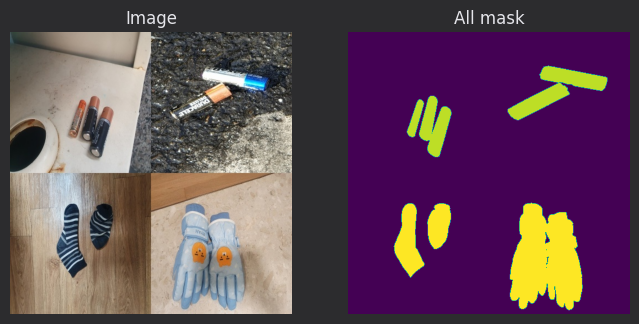

In [40]:
dataset = CustomDataLoader(f'{ROOT}/{PATH}.json')
img,mask = dataset.get_masked_img(2630)
viz_img_mask(img,mask)